In [677]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({"font.size": 20, "xtick.direction": "in", "ytick.direction": "in"})

C = 299_800_000

In [678]:
def lim(function, target, l0, r0):
    converging = True

    while converging:
        l1, r1 = np.mean([l0, target]), np.mean([r0, target]) # Half the difference between the left/right hand value and the target
        l2, r2 = np.mean([l1, target]), np.mean([r1, target])

        fl0, fr0 = function(l0), function(r0)
        fl1, fr1 = function(l1), function(r2)
        fl2, fr2 = function(l2), function(r2)

        delta_l0, delta_r0 = np.abs(fl1 -fl0), np.abs(fr1 -fr0)
        delta_l1, delta_r1 = np.abs(fl2 -fl1), np.abs(fr2 -fr1)

        if delta_l1 < delta_l0 and delta_r1 < delta_r0: #limit is converging :)
            l0, r0 = l1, r1
        else: #limit is diverging >:(. This is assumed to be a numerical error rather than a mathematical property of the function.
            converging = False

    return np.mean([fl0, fr0]) #Given that the limit converges, it should lie somewhere between the left and right hand limits.

def kramers_kronig(omega, rho):
    assert len(omega) == len(rho), "All values in the function must have a corrisponding frequency."
    N = len(omega)

    sort = np.argsort(omega)
    unsort = np.argsort(sort)
    delta_omega = np.diff(omega[sort], append= 2*omega[sort][-1] -omega[sort][-2]) # Extrapolate the last value.
    delta_omega = delta_omega[unsort] # When approximatating an intergral to the sum of many rectangles, we must find the area by multiplying by the width of the rectangles.

    summation = np.zeros(N)
    integrand = np.zeros(N)

    for x, dx, rho_x, n in zip(omega, delta_omega, rho, np.arange(N)):
        numerator = -omega *np.log(rho_x /rho)
        denominator = omega**2 -x**2
        integrand= numerator/denominator

        ###### SOLVING LIMIT #####
        rho_func = lambda y: np.interp(y, omega, rho)
        integrand_func = lambda y: -x *np.log(rho_func(y)/rho_x) /(x**2 -y**2) # I have used x as the frequency and y as the integral variable. (instead of omega and x)

        integrand[n] = lim(integrand_func, x, x-dx, x+dx)

        summation += integrand *dx

    return 2/np.pi *summation

def recip(x):
    return C*1e-6 / x #converts um to THz or vice versa.

def format_ticks(x, pos):
    return f"{x:.1f}"  # Format the tick label with one decimal place

def gaussian(x, center, FWHM, normalisation_coeffient):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    return normalisation_coeffient *np.exp(exponent)

In [679]:
File = open("plotDataqq.txt", 'rt')
epac_data = np.loadtxt(File, delimiter = " ")
File.close()

displacement, bunch_profile = epac_data.T # Z displacement in um, bunch profile normalised to its peak(?)

time = displacement *1e-6 /C # in s
sampling_period = np.median(np.diff(time)) # should be regularly spaced anyway
number_of_samples = len(time)
#bunch_profile /= np.sum(bunch_profile) # normalise to its intergral

#bunch_profile[:100] = 0

In [680]:
padding = 10000 # number of samples to zero padd at the end of the bunch

time = np.append(time, time[-1] +sampling_period*np.arange(padding))
bunch_profile = np.append(bunch_profile, np.zeros(padding))
new_number_of_samples = len(bunch_profile) # = number_of_samples +padding

#time = np.append(sampling_period*np.arange(new_number_of_samples-2) -time[-1], time)
#bunch_profile = np.append(np.zeros(new_number_of_samples -2), bunch_profile)
#new_number_of_samples = len(bunch_profile)

In [681]:
FT = np.fft.rfft(bunch_profile, norm= "forward")
FT_freqs = np.fft.rfftfreq(new_number_of_samples, sampling_period)

FF = np.fft.rfft(bunch_profile, norm= "forward")
FF = np.abs(FF)**2
FF /= np.max(FF) #normalise to peak
FF_freqs = np.fft.rfftfreq(new_number_of_samples, sampling_period)

In [682]:
mock_datapoints = np.arange(1.1, 177 +1.1, 1.1) *1e12
mock_measurement = np.interp(mock_datapoints, FF_freqs, FF)

C:\Users\syf83691\AppData\Local\Temp\ipykernel_6784\2286099187.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


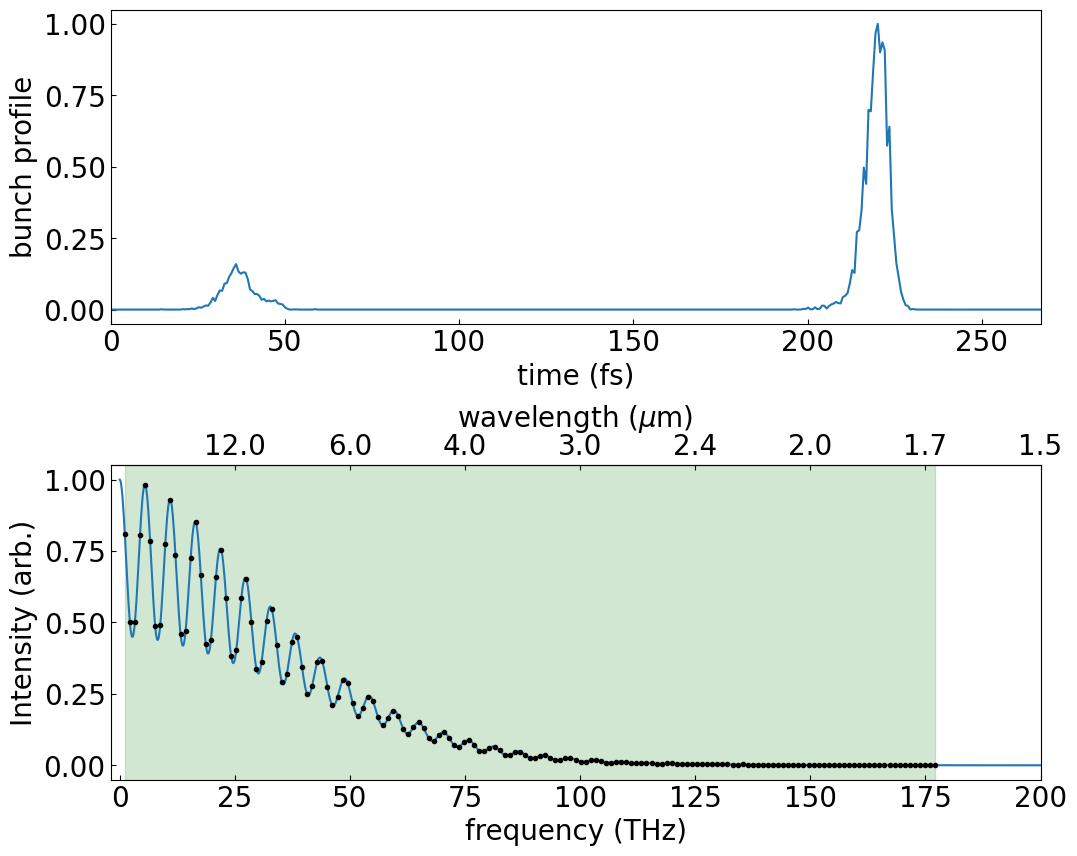

In [683]:
fig, axs = plt.subplots(2, 1, figsize= (12, 10), gridspec_kw= {"hspace": 0.45})

axs[0].plot(time *1e15, bunch_profile)
axs[0].set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (0, number_of_samples*sampling_period*1e15))

axs[1].plot(FF_freqs *1e-12, FF)
axs[1].plot(mock_datapoints *1e-12, mock_measurement, linestyle= "None", marker= ".", color= "k")
axs[1].set(xlabel= "frequency (THz)", ylabel= "Intensity (arb.)", xlim= (-2, 200))
axs[1].fill_betweenx([0,1], 2*[mock_datapoints.min() *1e-12], 2*[mock_datapoints.max() *1e-12], color= "forestgreen", alpha= 0.2, transform= axs[1].get_xaxis_transform())

secax = axs[1].secondary_xaxis('top', functions=(recip, recip))
secax.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[1].get_xticks()[2:]))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.show()

In [684]:
KK_freqs = FF_freqs *2*np.pi #switch to angular frequency in rad/s. This doesn't seem to matter?
KK_phase = kramers_kronig(KK_freqs, np.sqrt(FF)) #retive phase using KK relations

#FT_phase = np.unwrap(np.angle(FT)) #removes -pi, pi discontinuities in phase.

C:\Users\syf83691\AppData\Local\Temp\ipykernel_6784\2286099187.py:37: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator


In [685]:
############## FUDGE FACTORS FOR AMBIGUITY PROBLEM ############## 
""" There are 3 sources of ambiguity.
TIME SHIFT : Doesn't matter much. Can be resolved if you know (for example) when the peak occours.
REFLECTION : Slightly more problematic. Could be resolved if you know the order of the bunches.
INTERNAL STRUCTURE : Big issue with no obvious fix. Numberical methods like the Gerchberg-Saxton algorithm try to find the most probable internal structure.
"""

### REFLECTION
reflected = True
if reflected: fudged_phase = -KK_phase

KK = np.sqrt(FF) *np.exp(1j*fudged_phase) #apply phase
KK /= np.max(KK) #normalise
retrived_bunch = np.fft.irfft(KK, n= new_number_of_samples, norm= "forward")
retrived_bunch /= np.max(retrived_bunch) #normalise

### TIME SHIFT
peak_index = np.argmax(bunch_profile)
KK_peak_index = np.argmax(retrived_bunch)

#retrived_bunch = np.roll(retrived_bunch, peak_index -KK_peak_index) # Move the peak to the correct position
fudged_phase -= 2*np.pi*FF_freqs* sampling_period*(peak_index -KK_peak_index) # Equivalently, change the phase

KK = np.sqrt(FF) *np.exp(1j*fudged_phase) #apply phase
KK /= np.max(KK) #normalise
retrived_bunch = np.fft.irfft(KK, n= new_number_of_samples, norm= "forward")
retrived_bunch /= np.max(retrived_bunch) #normalise

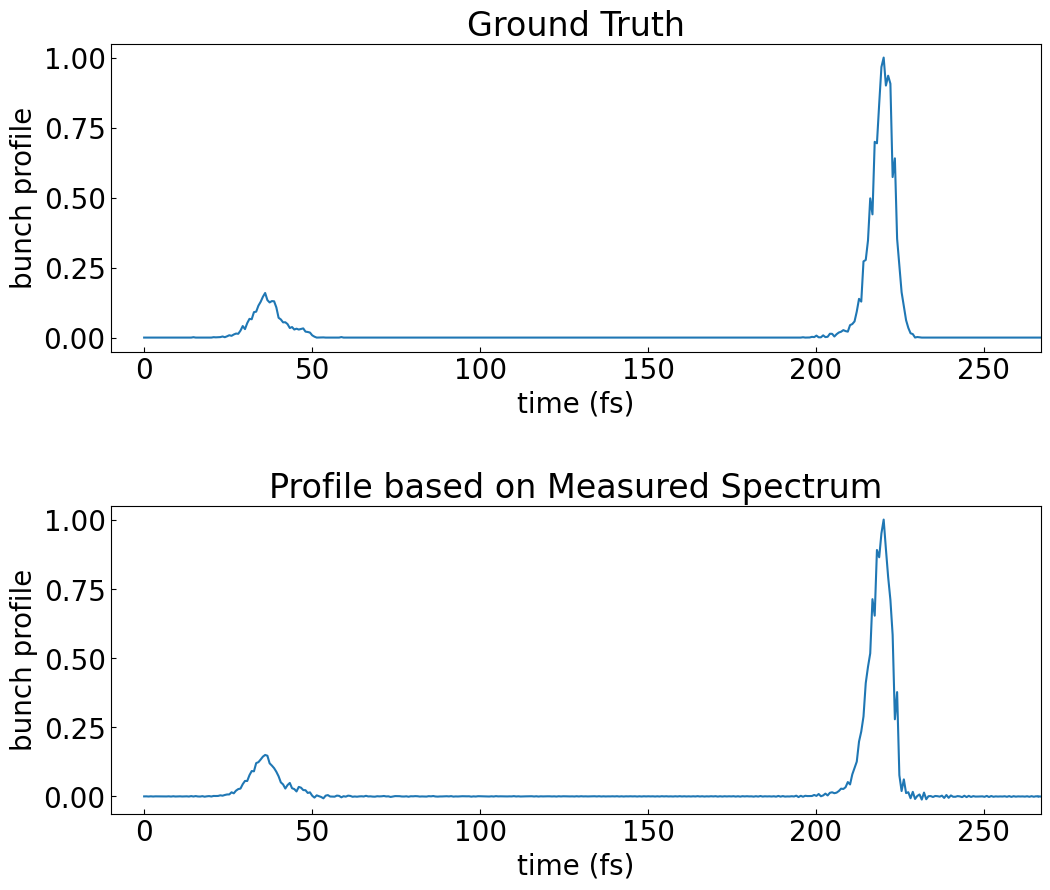

In [686]:
fig, axs = plt.subplots(2, 1, figsize= (12, 10), gridspec_kw= {"hspace": 0.5})

axs[0].plot(time *1e15, bunch_profile)
axs[0].set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (-10, number_of_samples*sampling_period*1e15), title= "Ground Truth")

axs[1].plot(time *1e15, retrived_bunch)
axs[1].set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (-10, number_of_samples*sampling_period*1e15), title= "Profile based on Measured Spectrum")

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_6784\2286099187.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


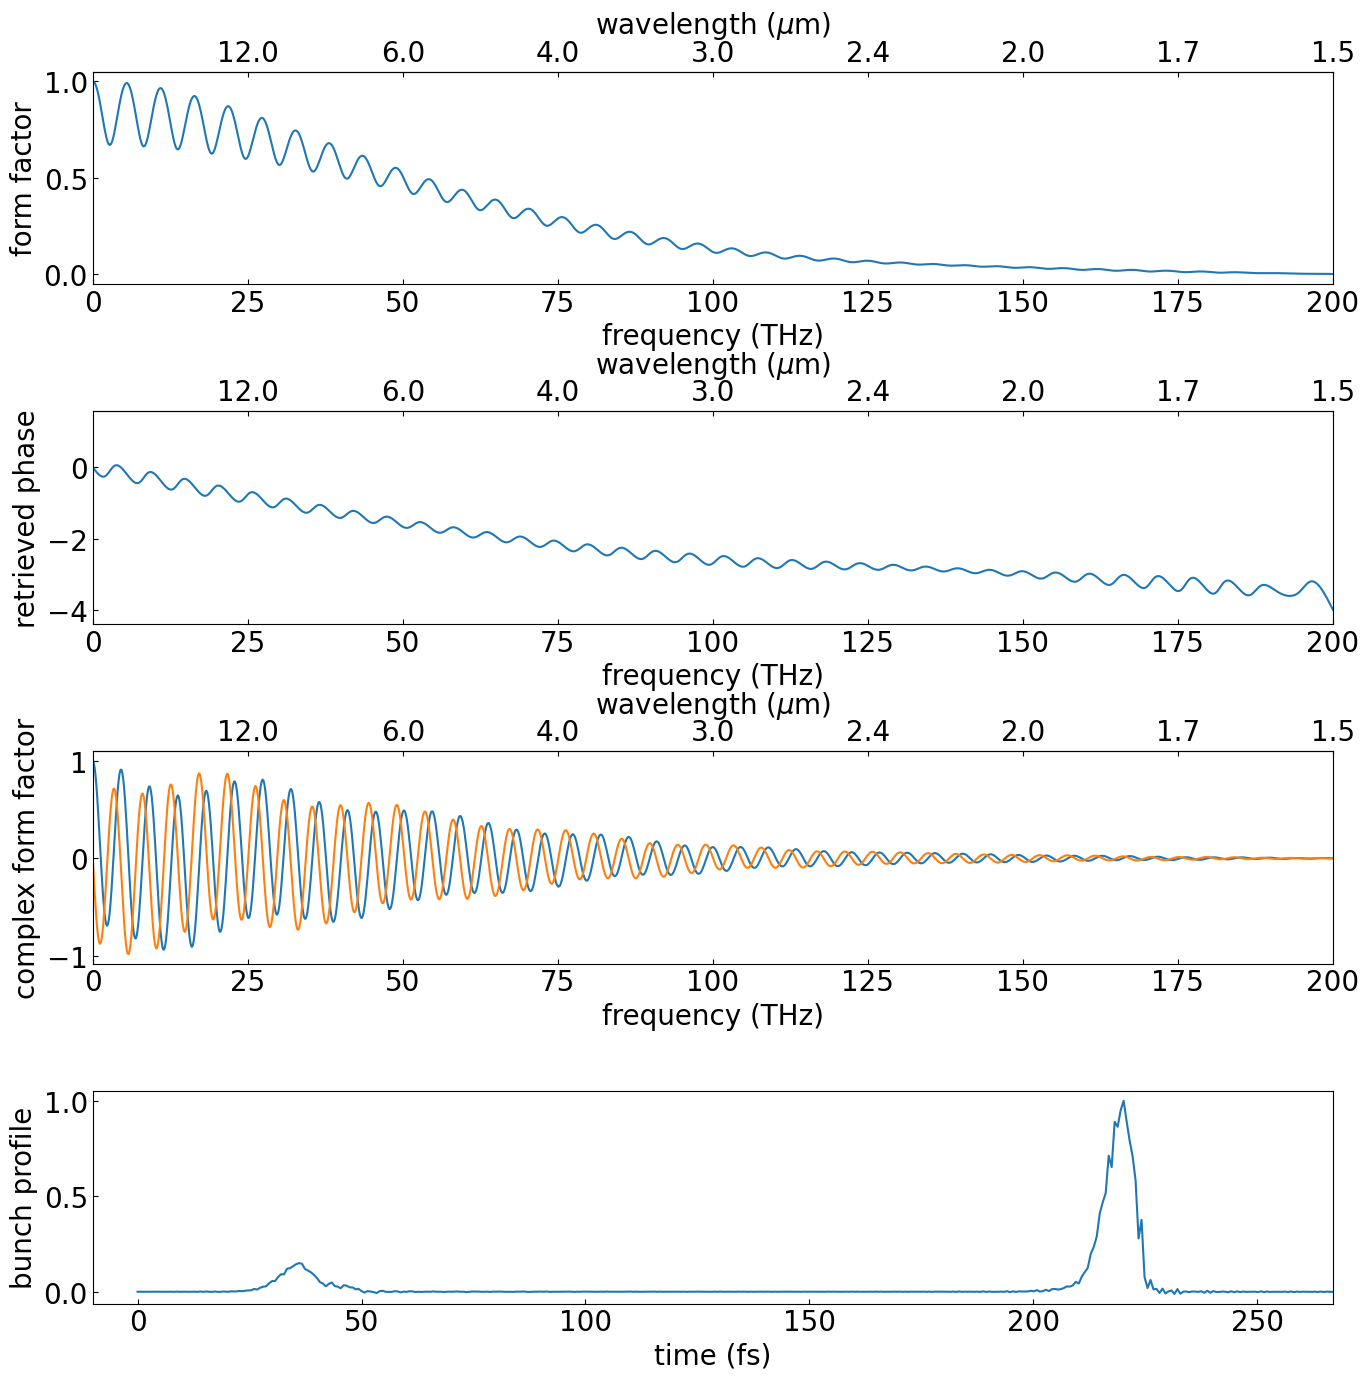

In [688]:
fig, axs = plt.subplots(4, 1, figsize= (16, 16), gridspec_kw= {"hspace": 0.6})

axs[0].plot(FF_freqs *1e-12, np.abs(KK))
axs[0].set(xlabel= "frequency (THz)", ylabel= "form factor", xlim= (1e-10, 200))

secax0 = axs[0].secondary_xaxis('top', functions=(recip, recip))
secax0.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[0].get_xticks()[1:]))
secax0.xaxis.set_major_formatter(FuncFormatter(format_ticks))

axs[1].plot(FF_freqs *1e-12, KK_phase)
axs[1].set(xlabel= "frequency (THz)", ylabel= "retrieved phase", xlim= (1e-10, 200))

secax1 = axs[1].secondary_xaxis('top', functions=(recip, recip))
secax1.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[1].get_xticks()[1:]))
secax1.xaxis.set_major_formatter(FuncFormatter(format_ticks))

axs[2].plot(FF_freqs *1e-12, KK.real)
axs[2].plot(FF_freqs *1e-12, KK.imag) 
axs[2].set(xlabel= "frequency (THz)", ylabel= "complex form factor", xlim= (1e-10, 200))

secax2 = axs[2].secondary_xaxis('top', functions=(recip, recip))
secax2.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[2].get_xticks()[1:]))
secax2.xaxis.set_major_formatter(FuncFormatter(format_ticks))

axs[3].plot(time *1e15, retrived_bunch)
axs[3].set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (-10, number_of_samples*sampling_period*1e15))

plt.show()